# Flight Pricing Analysis for Flight Price Prediction Dataset

##### Loading the Dataframe

In [0]:
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/apeacock@lassencollege.edu/Clean_Dataset_FlightPrices.csv")


#### Importing Dependencies

In [0]:
# Spark SQL and data processing
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, to_date, dayofweek
from pyspark.sql.types import IntegerType, FloatType, StringType
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F

# For machine learning
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler

# For data visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd




# Initialize Spark session
spark = SparkSession.builder.appName("Flight Recommendation System").getOrCreate()

In [0]:
df.show(5)

+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|_c0| airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  0|SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
|  1|SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|  2| AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|  3| Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|  4| Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
+---+--------+-------+-----------+------

#### Data Cleaning & Preprocessing

In [0]:
# Filter out rows where the class is not 'Economy'
df = df.filter(df['class'] == 'Economy')

# Convert 'duration' and 'days_left' from string to float and integer types respectively
df = df.withColumn("duration", col("duration").cast(FloatType())) \
       .withColumn("days_left", col("days_left").cast(IntegerType())) \
       .na.drop()  # Remove rows with null values

# Define a function to calculate IQR
def calculate_iqr(df, column):
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Remove outliers using IQR method
def remove_outliers(df, column):
    lower_bound, upper_bound = calculate_iqr(df, column)
    return df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

# Apply outlier removal to numerical columns (e.g., 'duration' and 'days_left')
numerical_columns = ['duration', 'days_left']
for column in numerical_columns:
    df = remove_outliers(df, column)

# Apply StringIndexer on categorical columns
categorical_cols = ["airline", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]

# Apply the indexers
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)

# Show the preprocessed DataFrame
df_indexed.show(5)

+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+-------------+-----------------+--------------------+-----------+------------------+----------------------+-----------+
|_c0| airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|airline_index|source_city_index|departure_time_index|stops_index|arrival_time_index|destination_city_index|class_index|
+---+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+-------------+-----------------+--------------------+-----------+------------------+----------------------+-----------+
|  0|SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|          5.0|              0.0|                 2.0|        1.0|               0.0|                   1.0|        0.0|
|  1|SpiceJet|SG-8157|      Delhi| Early_Mor

#### Summary Statistics

In [0]:
# Summary statistics for the 'price' column
price_summary = df.describe('price')
price_summary.show()

# Explore data samples near the minimum and maximum prices
min_price = df.select('price').agg(F.min('price')).first()[0]
max_price = df.select('price').agg(F.max('price')).first()[0]
print("Minimum price:", min_price)
print("Maximum price:", max_price)

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|            203748|
|   mean| 6513.162715707639|
| stddev|3694.6830092190016|
|    min|            1105.0|
|    max|           42349.0|
+-------+------------------+

Minimum price: 1105.0
Maximum price: 42349.0


#### Distribution of categorical variables

In [0]:
# Count flights per airline
df.groupBy('airline').count().show()

# Count flights per source city
df.groupBy('source_city').count().show()

# Count flights per class
df.groupBy('class').count().show()

+---------+-----+
|  airline|count|
+---------+-----+
|   Indigo|43120|
| SpiceJet| 9011|
|Air_India|45923|
|  AirAsia|16098|
| GO_FIRST|23173|
|  Vistara|66423|
+---------+-----+

+-----------+-----+
|source_city|count|
+-----------+-----+
|     Mumbai|40687|
|      Delhi|42705|
|  Bangalore|35045|
|    Kolkata|32268|
|  Hyderabad|27634|
|    Chennai|25409|
+-----------+-----+

+-------+------+
|  class| count|
+-------+------+
|Economy|203748|
+-------+------+



#### Relationships between Variables

In [0]:


# Convert 'price' from string to float
df = df.withColumn("price", col("price").cast(FloatType()))

# Average price per number of days left
df.groupBy('days_left').avg('price').orderBy('days_left').show()


# Average duration per departure time 
df.groupBy('departure_time').avg('duration').orderBy('departure_time').show()

# Average Price per Airline and Stops
df.groupBy('airline', 'stops').avg('price').orderBy('airline', 'stops').show()

# Average Duration per Source City
df.groupBy('source_city').avg('duration').orderBy('source_city').show()



+---------+------------------+
|days_left|        avg(price)|
+---------+------------------+
|        1|14477.654761904761|
|        2|13820.137440758293|
|        3|13076.267083027185|
|        4|10826.907151442309|
|        5| 10547.53035610041|
|        6|10260.817769477055|
|        7|10392.741318020235|
|        8|10410.150213447172|
|        9| 11279.67100166021|
|       10| 11128.02500658068|
|       11| 9528.265447813006|
|       12| 9250.924689083371|
|       13| 9307.386669710111|
|       14|  9370.29488372093|
|       15|  8318.17258176757|
|       16| 6237.553849787435|
|       17| 6109.338047445255|
|       18| 5392.020485415275|
|       19| 5298.351285460993|
|       20| 5244.767765075096|
+---------+------------------+
only showing top 20 rows

+--------------+------------------+
|departure_time|     avg(duration)|
+--------------+------------------+
|     Afternoon| 9.750013064147288|
| Early_Morning|10.857458208977366|
|       Evening|12.444985302087861|
|    Late_Nigh

#### Correlation

In [0]:


# Convert to vector column first 
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=['duration', 'days_left', 'price'], outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# Get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
correlation_matrix = matrix.collect()[0][0]
print(str(correlation_matrix).replace('nan', 'NaN'))

DenseMatrix([[ 1.        , -0.03233383,  0.26364015],
             [-0.03233383,  1.        , -0.5593477 ],
             [ 0.26364015, -0.5593477 ,  1.        ]])


#### EDA Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


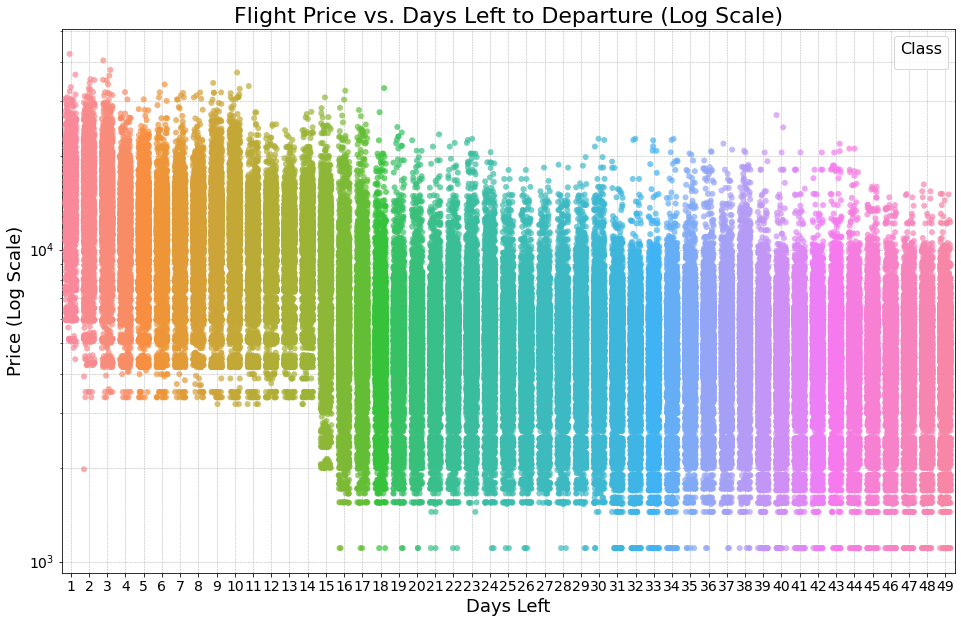

In [0]:


# Convert the Spark DataFrame to a Pandas DataFrame
sample_df = df.toPandas()

# Set the figure size for good readability
plt.figure(figsize=(16, 10))

# Adding jitter and plotting on a log scale for price
sns.stripplot(x='days_left', y='price', data=sample_df, jitter=0.3, dodge=True, alpha=0.7, size=6)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Add grid lines and customize further for clarity
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Flight Price vs. Days Left to Departure (Log Scale)', fontsize=22)
plt.xlabel('Days Left', fontsize=18)
plt.ylabel('Price (Log Scale)', fontsize=18)
plt.xticks(fontsize=14)  # Increase x-axis tick size
plt.yticks(fontsize=14)  # Increase y-axis tick size
plt.legend(title='Class', title_fontsize='16', fontsize='14', loc='upper right')

# Show the plot
plt.show()

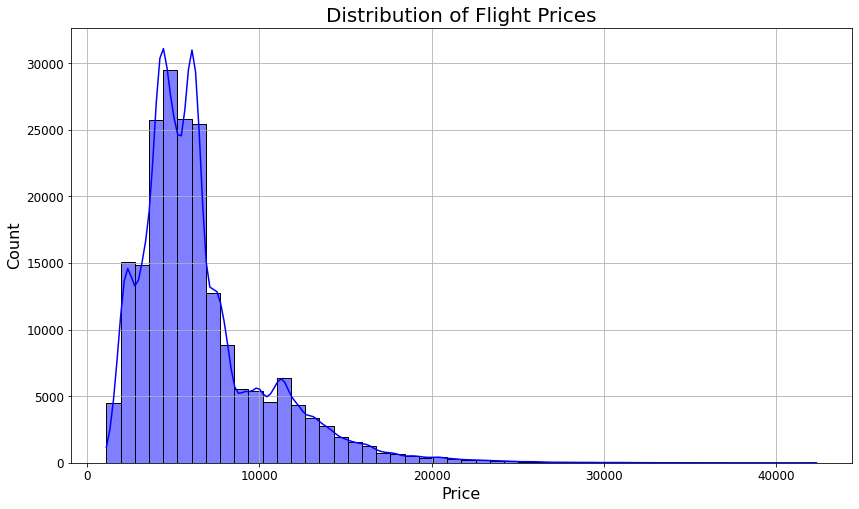

In [0]:
plt.figure(figsize=(14, 8))  # Setting the figure size for better readability

# Create the histogram
sns.histplot(sample_df['price'], bins=50, kde=True, color='blue')  # Adjust 'bins' as needed

# Enhance the plot
plt.title('Distribution of Flight Prices', fontsize=20)  # Adding a title
plt.xlabel('Price', fontsize=16)  # X-axis label
plt.ylabel('Count', fontsize=16)  # Y-axis label

plt.xticks(fontsize=12)  # Increase x-axis tick size
plt.yticks(fontsize=12)  # Increase y-axis tick size

plt.grid(True)  # Add grid for better readability
plt.show()

#### Duration and price, the building blocks of customer utility

Out[20]: <AxesSubplot:>

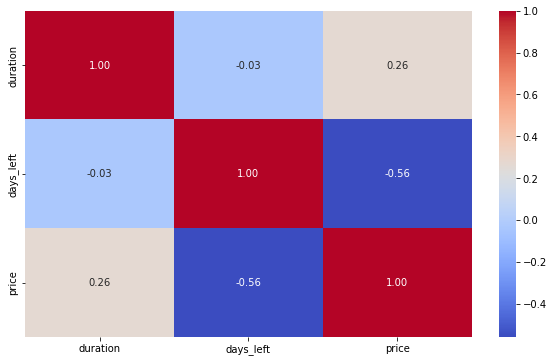

In [0]:
# Using seaborn to create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sample_df[['duration', 'days_left', 'price']].corr(), annot=True, cmap='coolwarm', fmt=".2f")

#### Price/Duration/Time until Departure: Training and evaluating a linear regression model 
Many consumers are interested in what "magic day" prior to the flight they should be buying tickets in order to get a low duration flight at a low price. 

## Model Training and Evaluation

We train and evaluate three regression models: Linear Regression, Random Forest Regression, and Gradient Boosted Tree Regression using the provided flight dataset. After converting the 'price' column to float type and splitting the data into training and testing sets, we assemble the features using VectorAssembler. For each model, we define the evaluation metric as root mean squared error (RMSE) and set up parameter grids for hyperparameter tuning. We then perform cross-validation to train the models and select the best hyperparameters. Finally, we evaluate the models on the test data and print the RMSE along with the best parameters for each model.

In [0]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import FloatType
from pyspark.ml.evaluation import RegressionEvaluator

# Convert 'price' from string to float
df = df.withColumn("price", col("price").cast(FloatType()))

# Split the data
(train_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)

# Assemble features using VectorAssembler
assembler = VectorAssembler(inputCols=["duration", "days_left"], outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Define evaluation metric
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# Models and their respective parameter grids
models_params = {
    LinearRegression(featuresCol='features', labelCol='price'): 
        ParamGridBuilder()
            .addGrid(LinearRegression.regParam, [0.1, 0.01])
            .addGrid(LinearRegression.elasticNetParam, [0.0, 0.5, 1.0])
            .addGrid(LinearRegression.maxIter, [10, 100])
            .build(),
    RandomForestRegressor(featuresCol='features', labelCol='price'): 
        ParamGridBuilder()
            .addGrid(RandomForestRegressor.maxDepth, [5, 10])
            .addGrid(RandomForestRegressor.numTrees, [10, 20])
            .build(),
    
    GBTRegressor(featuresCol='features', labelCol='price', maxIter=20): 
         ParamGridBuilder()
             .addGrid(GBTRegressor.maxDepth, [3, 5])
             .addGrid(GBTRegressor.stepSize, [0.1, 0.01])
             .build()
}

# Perform model training and evaluation
for model, param_grid in models_params.items():
    print(f"\nTraining {model.__class__.__name__}")
    
    # Set up cross-validation
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=3)
    
    # Fit the model
    cvModel = crossval.fit(train_data)
    
    # Predict and evaluate
    predictions = cvModel.transform(test_data)
    rmse = evaluator.evaluate(predictions)
    
    print("RMSE on test data:", rmse)
    
    # Print best parameters
    print("Best parameters:")
    for param, value in cvModel.bestModel.extractParamMap().items():
        print(f"{param.name}: {value}")


Training LinearRegression
RMSE on test data: 2952.8707671797583
Best parameters:
aggregationDepth: 2
elasticNetParam: 0.0
epsilon: 1.35
featuresCol: features
fitIntercept: True
labelCol: price
loss: squaredError
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
regParam: 0.0
solver: auto
standardization: True
tol: 1e-06

Training RandomForestRegressor
RMSE on test data: 2482.8228160828935
Best parameters:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: features
impurity: variance
labelCol: price
leafCol: 
maxBins: 32
maxDepth: 5
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 20
predictionCol: prediction
seed: 2502083311556356884
subsamplingRate: 1.0

Training GBTRegressor
RMSE on test data: 2463.420055451417
Best parameters:
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: features
impurity: variance
labelCol: price
leafCol: 
lossType: sq

#### Model Selection: RandomForestRegressor

After evaluating multiple regression models, including LinearRegression, RandomForestRegressor, and GBTRegressor, we have chosen RandomForestRegressor as the underlying model for our flight recommendation system. This decision was based on several factors. Firstly, RandomForestRegressor demonstrated a strong predictive performance, achieving an RMSE of aproximately 2500 (INR), which was comparable to GBTRegressor and significantly better than LinearRegression. Secondly, RandomForestRegressor is known for its robustness to overfitting, thanks to its ensemble nature and random feature selection. This characteristic is particularly valuable in our context, as it helps ensure the model generalizes well to unseen data. Additionally, RandomForestRegressor's ability to handle high-dimensional data and its inherent parallelization make it computationally efficient and suitable for our dataset. While interpretability may be slightly compromised compared to a single decision tree, the benefits of improved accuracy and reduced overfitting outweigh this limitation.

#### New Spark Session for Modularity and Isolation

In [0]:
spark = SparkSession.builder.appName("Flight Utility Analysis").getOrCreate()

#### Assigning utility scores by user-defined weights


In [0]:


# Assume user-defined weights are stored in variables user_price_weight and user_duration_weight
user_price_weight = 0.7
user_duration_weight = 0.3

# Calculate min and max values for price and duration
price_range = df.select(
    F.min(F.col("price")).alias("min_price"),
    F.max(F.col("price")).alias("max_price")
).first()

duration_range = df.select(
    F.min(F.col("duration")).alias("min_duration"),
    F.max(F.col("duration")).alias("max_duration")
).first()

# Assign values to variables
min_price = price_range['min_price']
max_price = price_range['max_price']
min_duration = duration_range['min_duration']
max_duration = duration_range['max_duration']

# Normalize price and duration columns
df = df.withColumn("normalized_price", (F.col("price") - min_price) / (max_price - min_price)) \
       .withColumn("normalized_duration", (F.col("duration") - min_duration) / (max_duration - min_duration))

# Calculate utility score using user-defined weights
df = df.withColumn("utility_score", user_price_weight * (1 - F.col("normalized_price")) + user_duration_weight * (1 - F.col("normalized_duration")))

# Show the resulting DataFrame with the utility scores
df.select("airline", "source_city", "destination_city", "duration", "days_left", "price", "utility_score").show()


+---------+-----------+----------------+--------+---------+------+------------------+
|  airline|source_city|destination_city|duration|days_left| price|     utility_score|
+---------+-----------+----------------+--------+---------+------+------------------+
| SpiceJet|      Delhi|          Mumbai|    2.17|        1|5953.0|0.9031484434181914|
| SpiceJet|      Delhi|          Mumbai|    2.33|        1|5953.0|0.9014086843003276|
|  AirAsia|      Delhi|          Mumbai|    2.17|        1|5956.0|0.9030975269212465|
|  Vistara|      Delhi|          Mumbai|    2.25|        1|5955.0|0.9022446195279629|
|  Vistara|      Delhi|          Mumbai|    2.33|        1|5955.0| 0.901374739969031|
|  Vistara|      Delhi|          Mumbai|    2.33|        1|5955.0| 0.901374739969031|
|  Vistara|      Delhi|          Mumbai|    2.08|        1|6060.0|0.9023110387900635|
|  Vistara|      Delhi|          Mumbai|    2.17|        1|6060.0|0.9013324216938194|
| GO_FIRST|      Delhi|          Mumbai|    2.17|     

In [0]:
# Group by 'days_left' and calculate average 'utility_score'
avg_utility_by_days_left = df.groupBy('days_left').agg(
    F.avg('utility_score').alias('avg_utility_score')
).orderBy('days_left')

# Show the results
avg_utility_by_days_left.show()

+---------+------------------+
|days_left| avg_utility_score|
+---------+------------------+
|        1|0.6417616590435492|
|        2|0.6563531941793888|
|        3|0.6653616372770234|
|        4|0.7076058580892497|
|        5|0.7176295257207919|
|        6|0.7286052589237767|
|        7|0.7254065676131806|
|        8|0.7271543139344441|
|        9|0.7089742314852608|
|       10|0.7112249347641422|
|       11|0.7446477448148149|
|       12|0.7494156494398401|
|       13|0.7488331010025755|
|       14| 0.748033017780808|
|       15|0.7652397631453667|
|       16|0.7999857665408869|
|       17|0.8011359677125263|
|       18|0.8150755262390644|
|       19|0.8164884881897734|
|       20|0.8181167617391629|
+---------+------------------+
only showing top 20 rows



### Tracking the Utility Score of all airlines, destination/departure combined

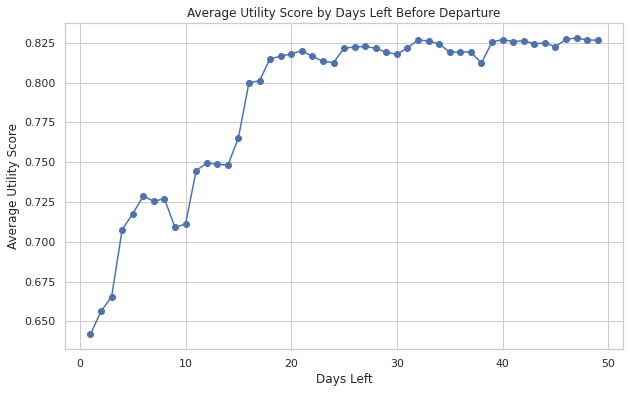

In [0]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pd_avg_utility_by_days_left = avg_utility_by_days_left.toPandas()

# Import plotting library
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pd_avg_utility_by_days_left['days_left'], pd_avg_utility_by_days_left['avg_utility_score'], marker='o')
plt.title('Average Utility Score by Days Left Before Departure')
plt.xlabel('Days Left')
plt.ylabel('Average Utility Score')
plt.grid(True)
plt.show()

In [0]:

# Group by 'airline' and 'days_left' and calculate average 'utility_score'
avg_utility_by_airline_days = df.groupBy('airline', 'days_left').agg(
    F.avg('utility_score').alias('avg_utility_score')
).orderBy('airline', 'days_left')

# Show the results (you might want to show more rows to get a better overview)
avg_utility_by_airline_days.show(50)

+---------+---------+------------------+
|  airline|days_left| avg_utility_score|
+---------+---------+------------------+
|  AirAsia|        1|0.7447590666000582|
|  AirAsia|        2|0.7782993105449715|
|  AirAsia|        3|0.7902453982380924|
|  AirAsia|        4| 0.814642968822512|
|  AirAsia|        5|0.7969665260009565|
|  AirAsia|        6|0.7931741838220309|
|  AirAsia|        7|0.7935085167008232|
|  AirAsia|        8|0.7848712222794981|
|  AirAsia|        9|0.7775992971283507|
|  AirAsia|       10| 0.759529873762858|
|  AirAsia|       11|0.8144239040472485|
|  AirAsia|       12|0.8211802600568422|
|  AirAsia|       13|0.8194814098344895|
|  AirAsia|       14|0.8163893207465355|
|  AirAsia|       15|0.8307862532595256|
|  AirAsia|       16|0.8538818598915967|
|  AirAsia|       17|0.8582947179378954|
|  AirAsia|       18|0.8708108466180191|
|  AirAsia|       19|0.8710885295425045|
|  AirAsia|       20|0.8750258197196689|
|  AirAsia|       21|0.8788846165049697|
|  AirAsia|     

### Breaking Down Utility Score by Airline and Days until Departure

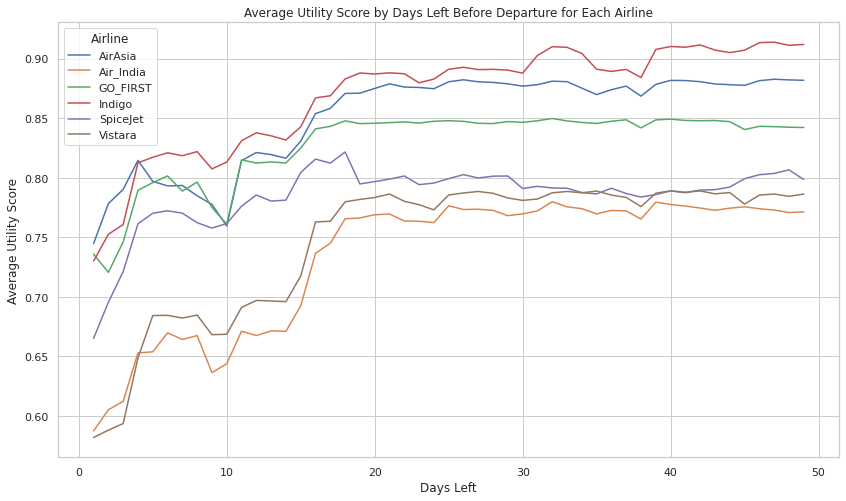

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
pd_avg_utility_by_airline_days = avg_utility_by_airline_days.toPandas()

# Pivot the DataFrame for easier plotting
pivot_df = pd_avg_utility_by_airline_days.pivot(index='days_left', columns='airline', values='avg_utility_score')

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, dashes=False)
plt.title('Average Utility Score by Days Left Before Departure for Each Airline')
plt.xlabel('Days Left')
plt.ylabel('Average Utility Score')
plt.legend(title='Airline')
plt.grid(True)
plt.show()

#### Identifying top Destination/Departure city pairs

In [0]:

# Count flights for each city pair and order by count
top_city_pairs = df.groupBy('source_city', 'destination_city').count().orderBy(F.desc('count'))

# Select the top 5 city pairs
top_city_pairs = top_city_pairs.limit(5)

# Collect city pairs into a list for filtering in subsequent steps
top_city_pairs_list = [(row['source_city'], row['destination_city']) for row in top_city_pairs.collect()]

#### Plotting utility scores for individual airlines, departure/destination pairs, days until departure

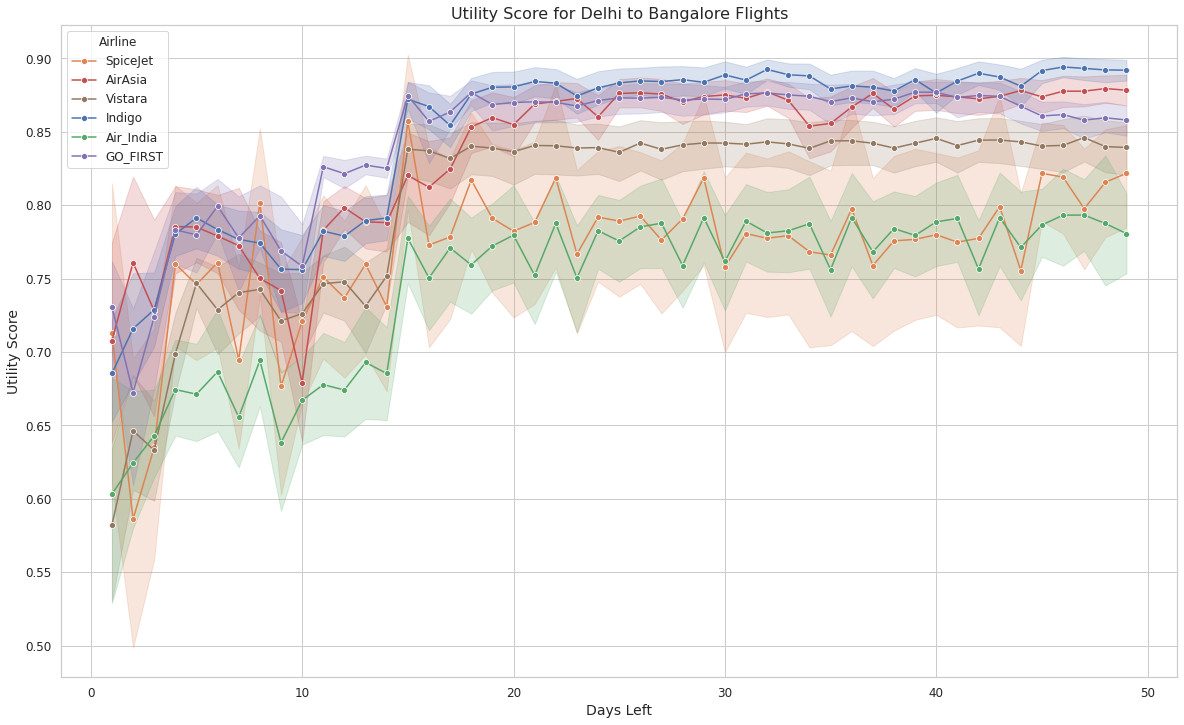

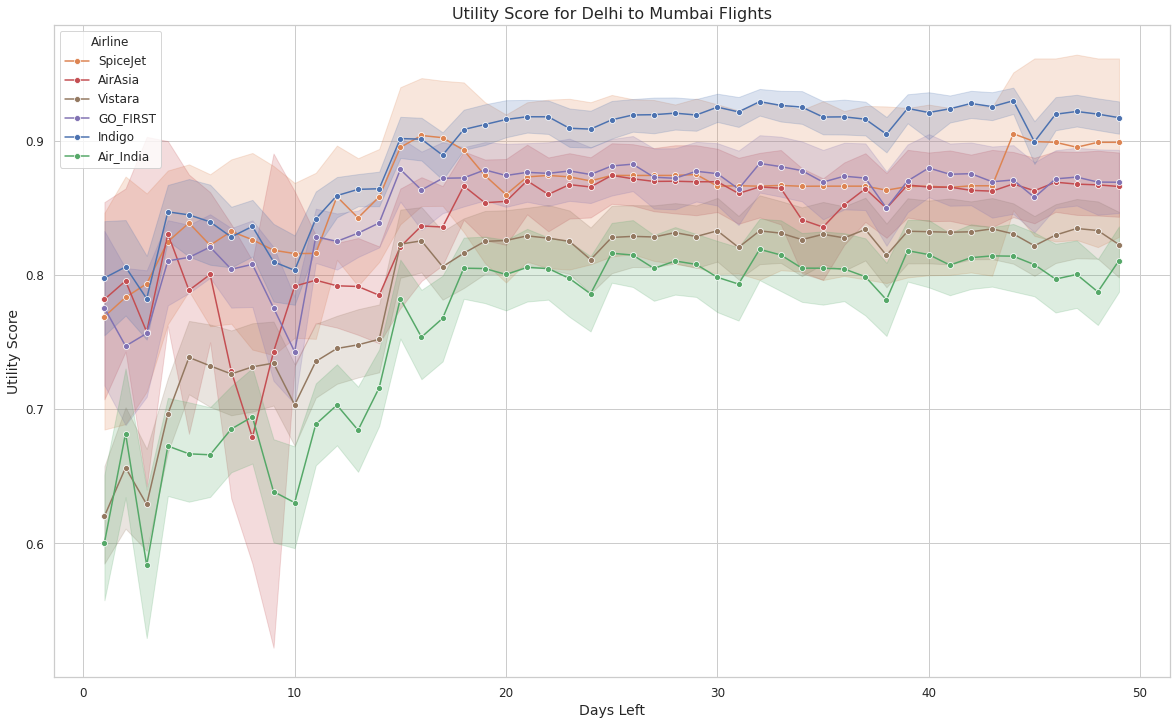

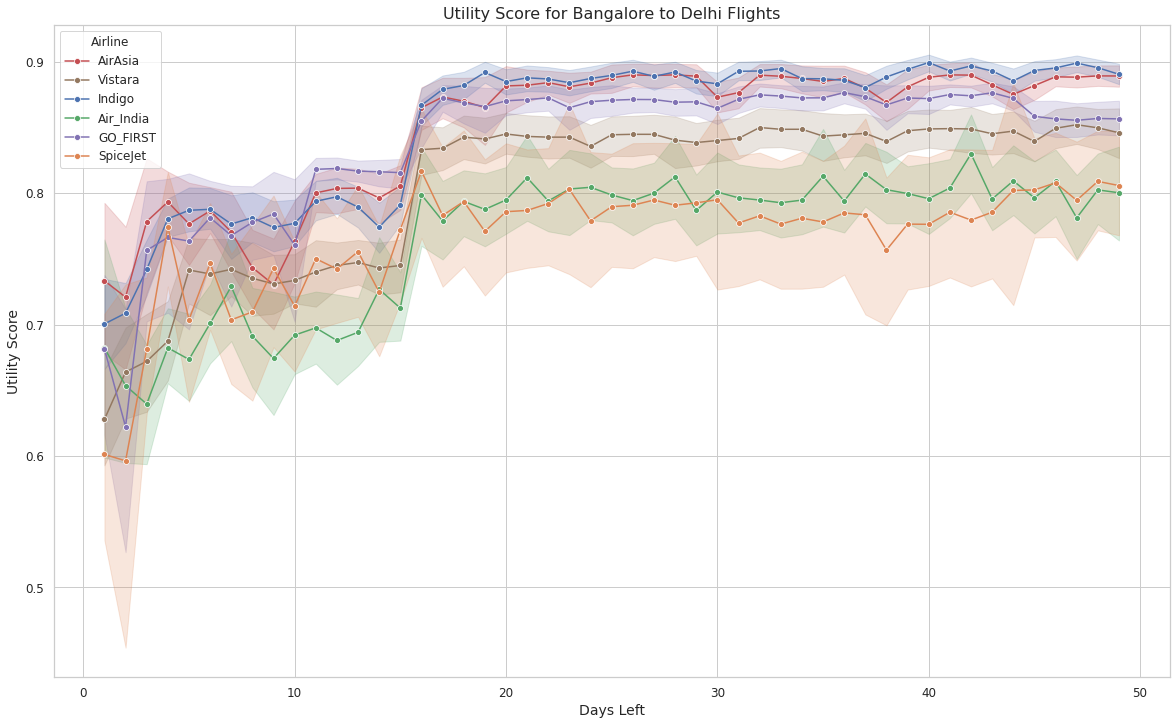

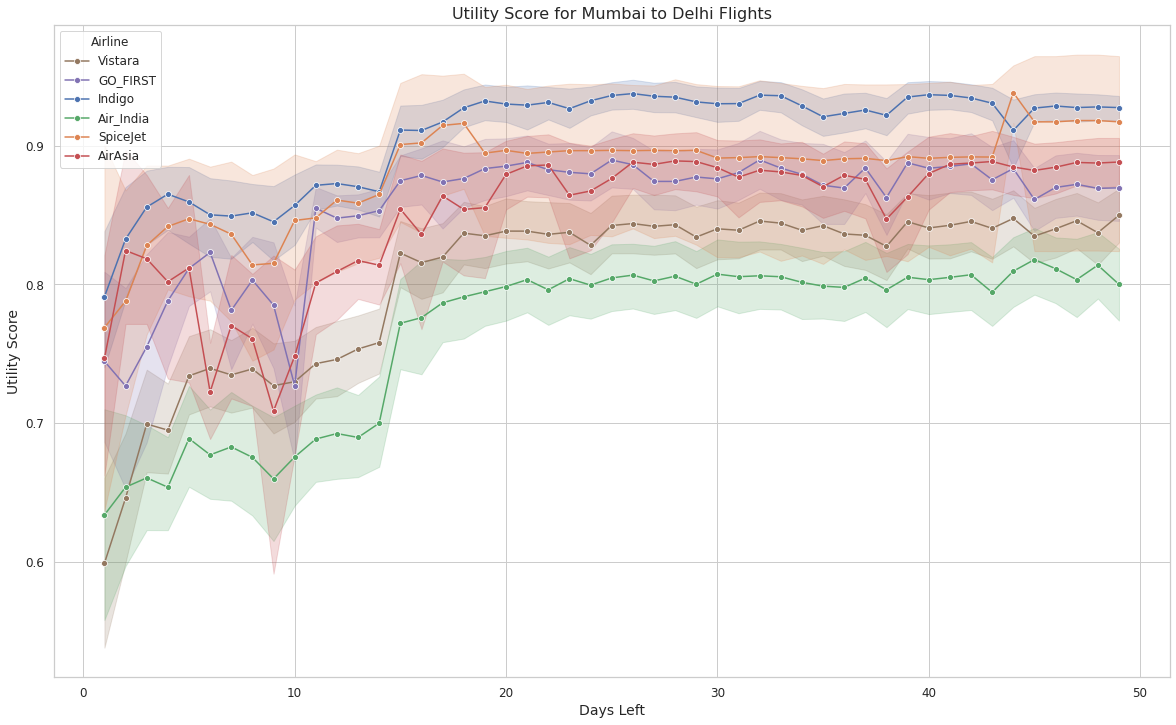

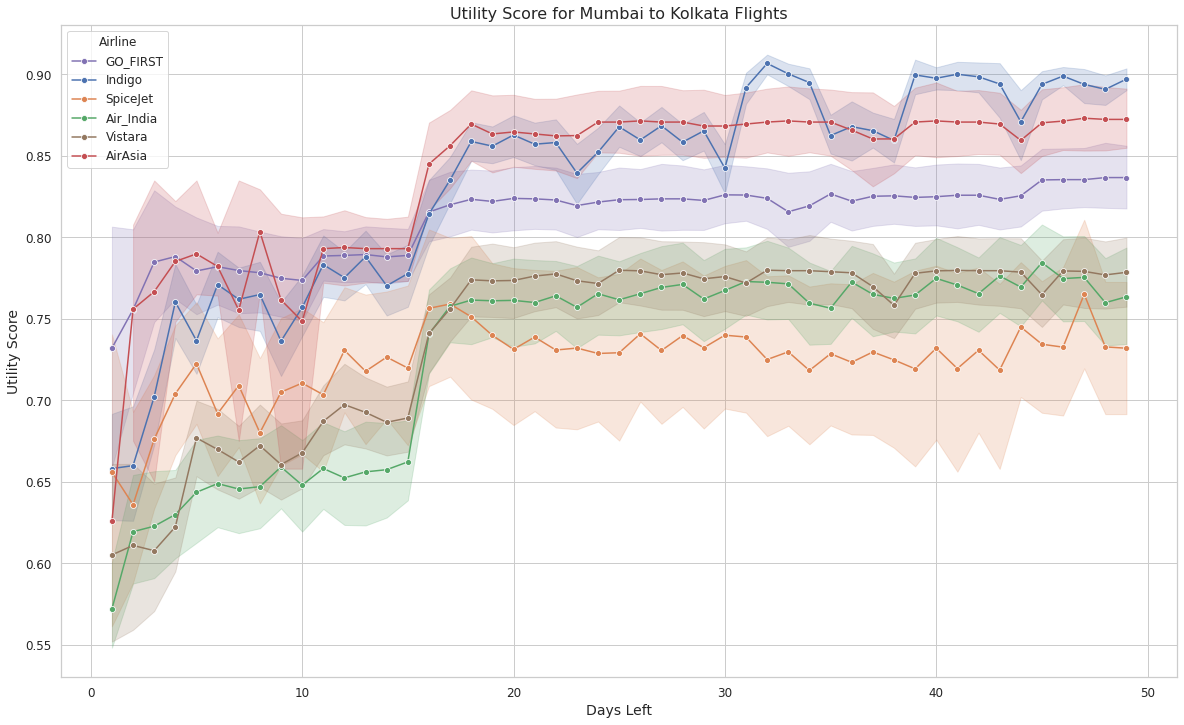

In [0]:
# Get unique values for the 'airline' column
unique_airlines = df.select('airline').distinct().collect()

# Convert the list of Row objects to a list of airline names
unique_airline_names = [row['airline'] for row in unique_airlines]

# Set plot style
sns.set(style="whitegrid")

# Create a color palette for airlines
airline_colors = {airline: color for airline, color in zip(unique_airline_names, sns.color_palette(n_colors=len(unique_airline_names)))}

# Iterate through the top city pairs
for i, city_pair in enumerate(top_city_pairs_list):
    # Filter data for the current city pair
    filtered_data = df.filter(
        (F.col('source_city') == city_pair[0]) & (F.col('destination_city') == city_pair[1])
    )
    
    # Convert to Pandas DataFrame for plotting
    pd_filtered_data = filtered_data.toPandas()
    
    # Create a new figure for each city pair
    plt.figure(figsize=(20, 12))
    
    # Plot each airline separately to assign colors
    for airline in pd_filtered_data['airline'].unique():
        airline_data = pd_filtered_data[pd_filtered_data['airline'] == airline]
        sns.lineplot(data=airline_data, x='days_left', y='utility_score', label=airline, color=airline_colors.get(airline, 'gray'), marker='o')
    
    # Set the title and labels with larger font sizes
    plt.title(f"Utility Score for {city_pair[0]} to {city_pair[1]} Flights", fontsize=16)
    plt.xlabel('Days Left', fontsize=14)
    plt.ylabel('Utility Score', fontsize=14)
    plt.legend(title='Airline', fontsize=12)
    
    # Adjust tick label font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Save the plot as a separate image file
    plt.savefig(f"utility_score_{city_pair[0]}_to_{city_pair[1]}.png")
    

    plt.show()